<a href="https://colab.research.google.com/github/AnthonyBurton-Cordova/Capstone/blob/main/SLADA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import json
from tensorflow import keras
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint, uniform
from collections import Counter
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive

# Suppress specific warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Determine the number of CPU cores to use for parallel processing
n_cores = multiprocessing.cpu_count()
print(f"Using {n_cores} CPU cores")

def improved_resampling(X, y):
    print("Original class distribution:")
    print(Counter(y))

    # Define resampling strategy
    over = SMOTE(sampling_strategy=0.5)  # Increase minority class to 50% of majority
    under = RandomUnderSampler(sampling_strategy=0.75)  # Reduce majority class to achieve 3:1 ratio

    # Chain the sampling strategies
    pipeline = Pipeline([('over', over), ('under', under)])

    # Fit and apply the resampling
    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    print("Resampled class distribution:")
    print(Counter(y_resampled))

    return X_resampled, y_resampled

def analyze_feature_importance(X, y):
    # Train a Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_
    feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return feature_importances

def create_nn_model(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def random_sample_csv(file_path, n_samples, random_state=None):
    # Get total number of rows
    total_rows = sum(1 for _ in open(file_path)) - 1  # Subtract 1 for header

    # Generate random row indices
    np.random.seed(random_state)
    skip_indices = np.random.choice(range(1, total_rows + 1),
                                    size=total_rows - n_samples,
                                    replace=False)
    skip_indices = np.sort(skip_indices)

    # Read the random sample
    df = pd.read_csv(file_path,
                     skiprows=skip_indices,
                     low_memory=False)

    return df


drive.mount('/content/drive')

# Specify the file path of the dataset
file_path = '/content/drive/MyDrive/SLADA_Project/Datasets/merged_data.csv'

# Load the random data into the dataframe
print("Loading a random sample of the dataset...")
df = random_sample_csv(file_path, n_samples=1500000, random_state=42)
print(f"Loaded {len(df)} random samples from the dataset.")

Using 12 CPU cores
Mounted at /content/drive
Loading a random sample of the dataset...
Loaded 1500000 random samples from the dataset.


Label
Benign                      1244918
DDOS attack-HOIC              63958
DDoS attacks-LOIC-HTTP        53560
DoS attacks-Hulk              43124
Bot                           26500
FTP-BruteForce                17745
SSH-Bruteforce                17197
Infilteration                 14857
DoS attacks-SlowHTTPTest      12978
DoS attacks-GoldenEye          3868
DoS attacks-Slowloris          1026
DDOS attack-LOIC-UDP            171
Brute Force -Web                 55
Brute Force -XSS                 26
Label                            10
SQL Injection                     7
Name: count, dtype: int64
Dataset has 1500000 rows and 80 columns
Dataset shape after dropping columns with >50% missing values: (1500000, 79)
Timestamp column is not present in the dataset. Skipping Timestamp conversion.
Dst Port         float64
Protocol         float64
Flow Duration    float64
Tot Fwd Pkts     float64
Tot Bwd Pkts     float64
                  ...   
Idle Std         float64
Idle Max         floa

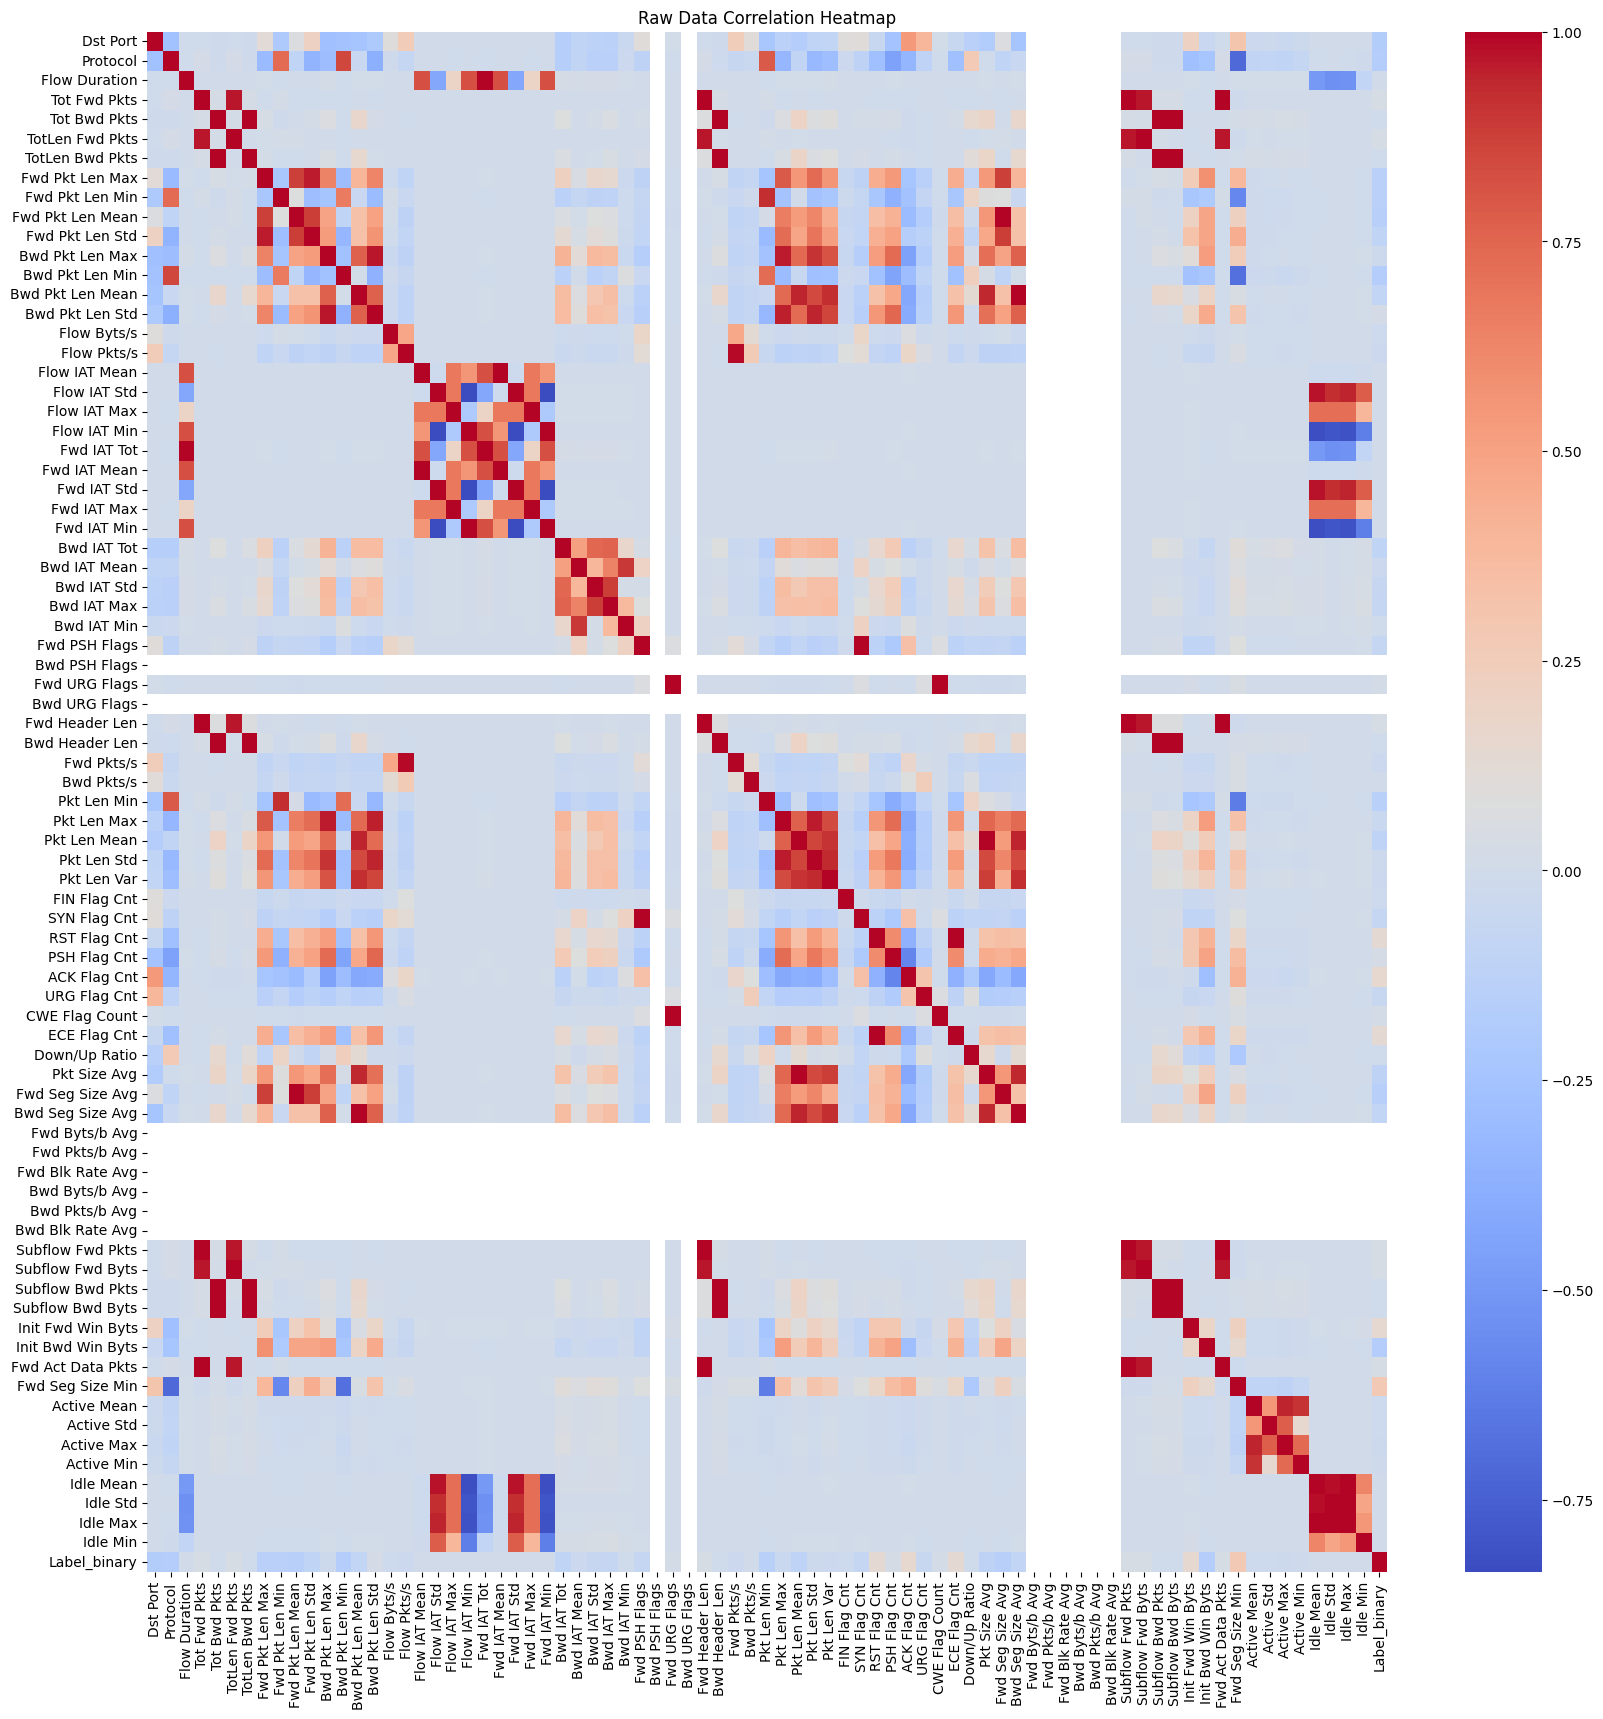

Highly correlated feature pairs:
Flow Duration and Fwd IAT Tot: 1.00
Tot Fwd Pkts and TotLen Fwd Pkts: 0.97
Tot Fwd Pkts and Fwd Header Len: 1.00
Tot Fwd Pkts and Subflow Fwd Pkts: 1.00
Tot Fwd Pkts and Subflow Fwd Byts: 0.97
Tot Fwd Pkts and Fwd Act Data Pkts: 1.00
Tot Bwd Pkts and TotLen Bwd Pkts: 1.00
Tot Bwd Pkts and Bwd Header Len: 1.00
Tot Bwd Pkts and Subflow Bwd Pkts: 1.00
Tot Bwd Pkts and Subflow Bwd Byts: 1.00
TotLen Fwd Pkts and Fwd Header Len: 0.97
TotLen Fwd Pkts and Subflow Fwd Pkts: 0.97
TotLen Fwd Pkts and Subflow Fwd Byts: 1.00
TotLen Fwd Pkts and Fwd Act Data Pkts: 0.97
TotLen Bwd Pkts and Bwd Header Len: 1.00
TotLen Bwd Pkts and Subflow Bwd Pkts: 1.00
TotLen Bwd Pkts and Subflow Bwd Byts: 1.00
Fwd Pkt Len Max and Fwd Pkt Len Std: 0.96
Fwd Pkt Len Mean and Fwd Seg Size Avg: 1.00
Bwd Pkt Len Max and Bwd Pkt Len Std: 0.97
Bwd Pkt Len Max and Pkt Len Max: 0.96
Bwd Pkt Len Mean and Bwd Seg Size Avg: 1.00
Bwd Pkt Len Std and Pkt Len Max: 0.95
Flow Pkts/s and Fwd Pkts/s: 0.

In [2]:
# Check if 'Label' column exists before further processing
if 'Label' in df.columns:
    # Print the count of instances in the Label column
    print(df['Label'].value_counts())
    # Create a copy of the Label column
    label_column = df['Label'].copy()
else:
    print("Label column is not present in the dataset.")
    exit()

# Drop unnecessary columns
columns_to_drop = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

# Ensure correct data types: convert all numeric columns
for col in df.columns:
    if df[col].dtype == 'object' and col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values: Drop columns with >50% missing values
missing_threshold = 0.5
df = df.dropna(thresh=int(missing_threshold * df.shape[0]), axis=1)
print(f"Dataset shape after dropping columns with >50% missing values: {df.shape}")

# Impute remaining missing values with median for numeric columns
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)

# Drop duplicate rows
df = df.drop_duplicates()

# Check if 'Timestamp' exists before processing it
if 'Timestamp' in df.columns:
    # Handle Timestamp (convert to Unix timestamp for easier processing)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    df['Timestamp_numeric'] = df['Timestamp'].astype(int) / 10**9  # Convert to Unix timestamp
    df['Hour'] = df['Timestamp'].dt.hour
    df = df.drop(columns=['Timestamp'])  # Drop original 'Timestamp' column after extraction
else:
    print("Timestamp column is not present in the dataset. Skipping Timestamp conversion.")

# Restore the Label column
df['Label'] = label_column

# Handle Label encoding
# Binary encode: 0 for Benign, 1 for any attack
df['Label_binary'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Now drop the 'Label_binary' and 'Label' from X when separating features
X = df.drop(columns=['Label', 'Label_binary'])
y = df['Label_binary']

# Print column types to ensure proper conversion
print(df.dtypes)

# Create a copy of the dataframe with only numeric columns for correlation analysis
df_numeric = df.select_dtypes(include=[np.number])

# Ensure we still have enough rows to proceed
print(f"Number of rows after preprocessing: {df_numeric.shape[0]}")

# Remove any remaining rows with missing values
df_numeric = df_numeric.dropna()

# Print correlation matrix for numeric data
raw_correlations = df_numeric.corr()

# Plot heatmap of raw correlations
plt.figure(figsize=(20, 20))
sns.heatmap(raw_correlations, cmap='coolwarm', annot=False)
plt.title("Raw Data Correlation Heatmap")
plt.show()

# Find highly correlated feature pairs (correlation > 0.95)
high_corr_pairs = []
for i in range(len(raw_correlations.columns)):
    for j in range(i+1, len(raw_correlations.columns)):
        if abs(raw_correlations.iloc[i, j]) > 0.95:
            high_corr_pairs.append((raw_correlations.columns[i], raw_correlations.columns[j], raw_correlations.iloc[i, j]))

print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

# Selectively remove only highly correlated features (using threshold > 0.95)
features_to_remove = set()
for pair in high_corr_pairs:
    features_to_remove.add(pair[1])  # Select one feature from each pair

print("Features to remove due to high correlation:")
print(features_to_remove)

# Create a reduced dataset by removing highly correlated features
df_reduced = df_numeric.drop(columns=features_to_remove)
print(f"Reduced dataset shape: {df_reduced.shape}")

# Replace infinite values with NaN and drop rows with missing values
df_reduced = df_reduced.replace([np.inf, -np.inf], np.nan).dropna()

# Add back the 'Label' and 'Label_numeric' columns
df_reduced['Label'] = label_column

In [ ]:
# Ensure 'Label_numeric' is preserved during feature reduction
if 'Label_binary' in df_reduced.columns:
    # Separate features (X) and target (y)
    X = df_reduced.drop(columns=['Label', 'Label_binary'])
    y = df_reduced['Label_binary']

    # Ensure the dataset has enough rows before splitting
    print(f"Final dataset shape: X={X.shape}, y={y.shape}")

    # Train-test split
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Apply improved resampling
        X_train_res, y_train_res = improved_resampling(X_train, y_train)

        # Feature importance analysis
        feature_importances = analyze_feature_importance(X_train_res, y_train_res)
        print("Top 10 most important features:")
        print(feature_importances.head(10))

        # Scaling features using PowerTransformer
        scaler = PowerTransformer()
        X_train_scaled = scaler.fit_transform(X_train_res)
        X_test_scaled = scaler.transform(X_test)

        # Save the scaler
        joblib.dump(scaler, 'scaler.joblib')
        print("Scaler saved as 'scaler.joblib'.")

        # Feature selection using Random Forest
        rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
        X_train_selected = rf_selector.fit_transform(X_train_scaled, y_train_res)
        X_test_selected = rf_selector.transform(X_test_scaled)

        # Save the selector
        joblib.dump(rf_selector, 'selector.joblib')
        print("Feature selector saved as 'selector.joblib'.")

        # Get the list of selected feature names
        selected_feature_indices = rf_selector.get_support(indices=True)
        selected_features = X.columns[selected_feature_indices]

        # Save the list of features
        joblib.dump(selected_features.tolist(), 'features_list.joblib')
        print("List of features saved as 'features_list.joblib'.")

        # Update param_grid for RandomizedSearchCV
        param_grid = {
            'Random Forest': {
                'n_estimators': randint(100, 500),
                'max_depth': randint(10, 50),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'max_features': ['auto', 'sqrt', 'log2']
            },
            'Decision Tree': {
                'max_depth': randint(10, 50),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'max_features': ['auto', 'sqrt', 'log2']
            },
            'Neural Network': {
                'hidden_layer_sizes': [(64, 32), (64, 32, 16), (32, 16)],
                'alpha': [0.0001, 0.001],
                'learning_rate': ['constant', 'adaptive'],
                'batch_size': [32, 64, 128]
            }
        }

        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
        class_weight_dict = dict(zip(np.unique(y_train_res), class_weights))

        # Define models
        models = [
            ('Logistic Regression', LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000, class_weight=class_weight_dict)),
            ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight_dict)),
            ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)),
            ('Neural Network', MLPClassifier(random_state=42, max_iter=1000))
        ]

        # Train and evaluate models
        for name, model in models:
            print(f"\nTraining {name}...")
            if name in param_grid:
                print(f"Performing RandomizedSearchCV for {name}...")
                random_search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_grid[name],
                    n_iter=50,
                    cv=skf,
                    n_jobs=-1,
                    random_state=42,
                    scoring='accuracy'
                )
                random_search.fit(X_train_selected, y_train_res)
                best_model = random_search.best_estimator_
                print(f"Best parameters for {name}: {random_search.best_params_}")
            else:
                print(f"Fitting {name} directly...")
                best_model = model.fit(X_train_selected, y_train_res)

            print(f"Making predictions with {name}...")
            y_pred = best_model.predict(X_test_selected)

            print(f"\n{name} Results:")
            print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
            print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")

            # Perform k-fold cross-validation
            if name != 'Neural Network':
                print(f"Performing cross-validation for {name}...")
                cv_scores = cross_val_score(best_model, X_train_selected, y_train_res, cv=skf, scoring='accuracy')
                print(f"Cross-validation scores: {cv_scores}")
                print(f"Mean CV score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
            else:
                print("Performing custom cross-validation for Neural Network...")
                # For Neural Network, we need to use the custom cross-validation approach
                cv_scores = []
                X_train_np = X_train_selected
                y_train_np = y_train_res.to_numpy()  # Convert pandas Series to numpy array
                for train_index, val_index in skf.split(X_train_np, y_train_np):
                    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
                    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]
                    nn_model = create_nn_model(X_train_np.shape[1])

                    nn_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, verbose=0)
                    y_pred_fold = (nn_model.predict(X_val_fold) > 0.5).astype(int)
                    cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))
                print(f"Cross-validation scores: {cv_scores}")
                print(f"Mean CV score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix - {name}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

            # Save the current best model
            joblib.dump(best_model, f'{name.lower().replace(" ", "_")}_model.joblib')
            print(f"Saved {name} model.")

        print("\nAll individual models trained and saved.")

        # Ensemble methods
        print("\nTraining Voting Classifier...")
        voting_clf = VotingClassifier(
            estimators=[
                ('lr', joblib.load('logistic_regression_model.joblib')),
                ('rf', joblib.load('random_forest_model.joblib')),
                ('dt', joblib.load('decision_tree_model.joblib'))
            ],
            voting='soft'
        )

        voting_clf.fit(X_train_selected, y_train_res)
        y_pred_voting = voting_clf.predict(X_test_selected)

        print("\nVoting Classifier Results:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred_voting)}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred_voting, zero_division=0)}")

        print("\nTraining Stacking Classifier...")
        base_models = [
            ('lr', joblib.load('logistic_regression_model.joblib')),
            ('rf', joblib.load('random_forest_model.joblib')),
            ('dt', joblib.load('decision_tree_model.joblib'))
        ]
        stacking_clf = StackingClassifier(
            estimators=base_models,
            final_estimator=LogisticRegression(random_state=42),
            cv=5
        )

        stacking_clf.fit(X_train_selected, y_train_res)
        y_pred_stacking = stacking_clf.predict(X_test_selected)

        print("\nStacking Classifier Results:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred_stacking, zero_division=0)}")

        # Find and save the best model
        print("\nDetermining the best model...")
        all_models = [
            ('Logistic Regression', joblib.load('logistic_regression_model.joblib')),
            ('Random Forest', joblib.load('random_forest_model.joblib')),
            ('Decision Tree', joblib.load('decision_tree_model.joblib')),
            ('Neural Network', joblib.load('neural_network_model.joblib')),
            ('Voting Classifier', voting_clf),
            ('Stacking Classifier', stacking_clf)
        ]

        best_model = None
        best_accuracy = 0

        for name, model in all_models:
            try:
                if isinstance(model, keras.Sequential):
                    y_pred = (model.predict(X_test_selected) > 0.5).astype(int)
                else:
                    y_pred = model.predict(X_test_selected)
                accuracy = accuracy_score(y_test, y_pred)
                print(f"{name} Accuracy: {accuracy:.4f}")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model
            except Exception as e:
                print(f"Error evaluating {name}: {str(e)}")

        if best_model:
            joblib.dump(best_model, 'best_traffic_classification_model.joblib')
            print(f"\nBest model ({type(best_model).__name__}) saved with accuracy: {best_accuracy:.4f}")
        else:
            print("No best model found. This should not happen.")

        # Summarize findings
        print("\nSummary of Findings:")
        print(f"- Initial dataset shape: {df.shape}")
        print(f"- Final dataset shape after preprocessing: {X.shape}")
        print(f"- Number of features used for modeling: {X_train_selected.shape[1]}")
        print(f"- Best model: {type(best_model).__name__}")
        print(f"- Best model accuracy: {best_accuracy:.4f}")

        # Class distribution analysis
        class_distribution = y.value_counts(normalize=True)
        print("\nClass Distribution:")
        print(class_distribution)

        plt.figure(figsize=(10, 6))
        class_distribution.plot(kind='bar')
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Proportion')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Feature Importance Analysis
        rf_model = joblib.load('random_forest_model.joblib')
        feature_importance = pd.DataFrame({
            'feature': X.columns[rf_selector.get_support()],
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features (Random Forest):")
        print(feature_importance.head(10))

        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title('Top 20 Most Important Features (Random Forest)')
        plt.tight_layout()
        plt.show()

        # Save important outputs
        output_data = {
            "initial_shape": list(df.shape),
            "final_shape": list(X.shape),
            "best_model": type(best_model).__name__,
            "best_accuracy": float(best_accuracy),
            "class_distribution": class_distribution.to_dict(),
            "top_features": feature_importance.head(10).to_dict(orient='records')
        }

        with open('traffic_analysis_results.json', 'w') as f:
            json.dump(output_data, f, indent=4)

        print("\nAnalysis results saved to 'traffic_analysis_results.json'")

        # Final message
        print("\nTraffic data analysis complete. Review the outputs, visualizations, and saved model for insights and next steps.")

        # Close all plots
        plt.close('all')

Final dataset shape: X=(1248983, 50), y=(1248983,)
Original class distribution:
Counter({0: 763505, 1: 110783})
Resampled class distribution:
Counter({0: 509002, 1: 381752})
